In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [2]:
df = pd.read_csv('../data/2019_2025_youthgas_1branch_Sheet1.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [3]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

In [4]:
window_size = 5
features = ['total_quantity', 'total_amount', 'max_amount', 'mean', 'min_amount']
targets = ['max_amount', 'mean', 'min_amount']
future_steps = 35

In [6]:
X_lags = []
for i in range(window_size, 0, -1):
    lag_df = df[features].shift(i)
    lag_df.columns = [f"{col}_lag{i}" for col in features]
    X_lags.append(lag_df)

X = pd.concat(X_lags + [df[['month', 'day', 'dayofweek']]], axis=1)

In [7]:
#타겟 데이터 생성(35일치)
y_list = []
for i in range(1, future_steps + 1):
    target_shift = df[targets].shift(-i)
    target_shift.columns = [f"{col}_step{i}" for col in targets]
    y_list.append(target_shift)

y = pd.concat(y_list, axis=1)

In [8]:
# 결측치 제거
data = pd.concat([X, y], axis=1).dropna()
X_final = data[X.columns]
y_final = data[y.columns]

# LightGBM 모델 정의 (MultiOutput 사용)
# 35일 * 3개 타겟 = 105개의 값을 동시에 예측해야 하므로 MultiOutputRegressor를 사용합니다.
lgbm = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model = MultiOutputRegressor(lgbm)
model.fit(X_final, y_final)

# 5. 모델 저장
joblib.dump(model, 'lgbm_flower_model.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 224, number of used features: 28
[LightGBM] [Info] Start training from score 1729.062500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

['lgbm_flower_model.pkl']

In [ ]:
# 학습/테스트 데이터 분리 (시계열이므로 shuffle=False 필수)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.1, shuffle=False)

# 모델 재학습 (테스트 데이터 제외)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 201, number of used features: 28
[LightGBM] [Info] Start training from score 1717.910448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,LGBMRegressor...ndom_state=42)
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


In [10]:
# 테스트 세트에서 하나의 샘플(예: 가장 최근 시점) 선택하여 예측
sample_idx = -1 # 가장 마지막 데이터 포인트
sample_pos = df.index.get_loc(X_test.index[sample_idx])
test_x_sample = X_test.iloc[[sample_idx]]
actual_y_sample = y_test.iloc[sample_idx]
predicted_y_sample = model.predict(test_x_sample)[0]

# 시각화를 위한 '평균가(mean)' 데이터 추출 (35일치)
steps = range(1, future_steps + 1)
actual_mean = [actual_y_sample[f'mean_step{i}'] for i in steps]

# 예측값 배열에서 mean_step 컬럼의 인덱스를 찾아 추출
mean_indices = [y_final.columns.get_loc(f'mean_step{i}') for i in steps]
predicted_mean = [predicted_y_sample[i] for i in mean_indices]

In [24]:
# 1. 월, 수, 금요일만 포함하는 커스텀 경매일 달력 정의
# weekmask에 포함된 요일만 '유효한 날'로 인식합니다.
auction_cal = CustomBusinessDay(weekmask='Mon Wed Fri')

# 2. 예측 시작 날짜 설정 (데이터셋의 마지막 날짜 다음 경매일부터 시작)
base_date = pd.to_datetime('2026-01-01')

# 3. 향후 35번의 '경매일' 날짜 생성
# freq=auction_cal을 설정하면 자동으로 월/수/금만 골라서 35개를 생성합니다.
prediction_dates = pd.date_range(
    start=base_date + auction_cal, 
    periods=future_steps, 
    freq=auction_cal
)

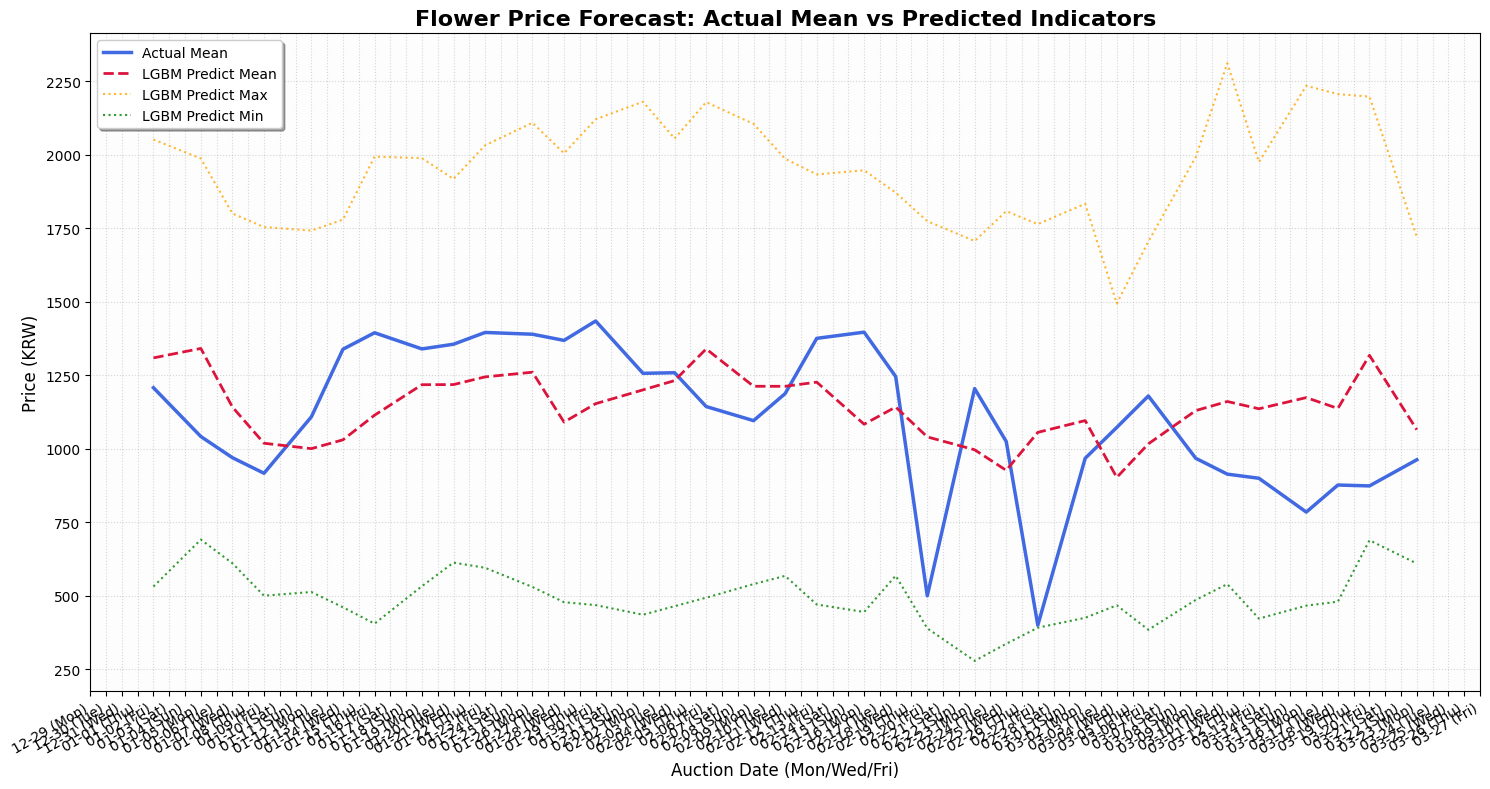

In [25]:
# 1. 데이터 추출 (Actual Mean & Predicted 3종)
steps = range(1, future_steps + 1)

# --- Actual (실제값) 추출: Mean만 사용 ---
actual_mean = [actual_y_sample[f'mean_step{i}'] for i in steps]

# --- Predicted (예측값) 추출: Max, Mean, Min ---
mean_idx = [y_final.columns.get_loc(f'mean_step{i}') for i in steps]
max_idx = [y_final.columns.get_loc(f'max_amount_step{i}') for i in steps]
min_idx = [y_final.columns.get_loc(f'min_amount_step{i}') for i in steps]

predicted_mean = [predicted_y_sample[i] for i in mean_idx]
predicted_max = [predicted_y_sample[i] for i in max_idx]
predicted_min = [predicted_y_sample[i] for i in min_idx]

# 2. 그래프 그리기
plt.figure(figsize=(15, 8))

# 실제값: Mean (실선)
plt.plot(prediction_dates, actual_mean, label='Actual Mean', color='royalblue', linewidth=2.5, zorder=3)

# 예측값: Mean (굵은 점선)
plt.plot(prediction_dates, predicted_mean, label='LGBM Predict Mean', color='crimson', linestyle='--', linewidth=2, zorder=4)

# 예측값: Max & Min (보조 점선)
plt.plot(prediction_dates, predicted_max, label='LGBM Predict Max', color='orange', linestyle=':', alpha=0.8)
plt.plot(prediction_dates, predicted_min, label='LGBM Predict Min', color='green', linestyle=':', alpha=0.8)

# --- x축 날짜 스타일링 ---
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d (%a)'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()

# 3. 그래프 꾸미기
plt.title('Flower Price Forecast: Actual Mean vs Predicted Indicators', fontsize=16, fontweight='bold')
plt.xlabel('Auction Date (Mon/Wed/Fri)', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.5)

# 가독성을 위해 배경색 살짝 추가 (선택 사항)
plt.gca().set_facecolor('#fdfdfd')

plt.tight_layout()
plt.show()

In [26]:
# 2026년 주요 공휴일 (월/수/금 중심)
kr_holidays_2026 = [
    '2026-01-01', '2026-02-16', '2026-02-17', '2026-02-18', 
    '2026-03-02', '2026-05-01', '2026-05-25', '2026-06-03', 
    '2026-08-17', '2026-09-24', '2026-09-25', '2026-10-05', 
    '2026-10-09', '2026-12-25'
]
auction_cal = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2026)

In [ ]:
# 데이터셋 생성 함수 (연도별 분리 학습)
def create_dataset(data, window, steps):
    X_list, y_list = [], []
    years = data['date'].dt.year.unique()
    
    for yr in years:
        yr_data = data[data['date'].dt.year == yr].copy()
        if len(yr_data) < (window + steps): continue
        
        # 날짜 정보 추가
        yr_data['month'] = yr_data['date'].dt.month
        yr_data['day'] = yr_data['date'].dt.day
        yr_data['dayofweek'] = yr_data['date'].dt.dayofweek
        
        for i in range(len(yr_data) - window - steps + 1):
            # X: 과거 5일 데이터 + 시점 정보
            x_win = yr_data[features].iloc[i : i + window].values.flatten()
            date_feats = yr_data[['month', 'day', 'dayofweek']].iloc[i + window - 1].values
            X_list.append(np.concatenate([x_win, date_feats]))
            
            # y: 향후 35일의 [max, mean, min] (총 105개 출력)
            y_win = yr_data[targets].iloc[i + window : i + window + steps].values.flatten()
            y_list.append(y_win)
            
    return np.array(X_list), np.array(y_list)

In [28]:
X_train, y_train = create_dataset(df, window_size, future_steps)
model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
model.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 3, number of used features: 0
[LightGBM] [Info] Start training from score 1350.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,LGBMRegressor...ndom_state=42)
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


In [ ]:
# 2026년 예측 수행 (2025년의 마지막 데이터를 입력으로 사용)
last_data_2025 = df[df['date'].dt.year == 2025].iloc[-window_size:].copy()
last_data_2025['month'] = last_data_2025['date'].dt.month
last_data_2025['day'] = last_data_2025['date'].dt.day
last_data_2025['dayofweek'] = last_data_2025['date'].dt.dayofweek

x_input = np.concatenate([
    last_data_2025[features].values.flatten(),
    last_data_2025[['month', 'day', 'dayofweek']].iloc[-1].values
]).reshape(1, -1)

forecast_raw = model.predict(x_input)[0]
forecast_reshaped = forecast_raw.reshape(future_steps, 3) # (35일, 3지표)

C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ktg08\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRe

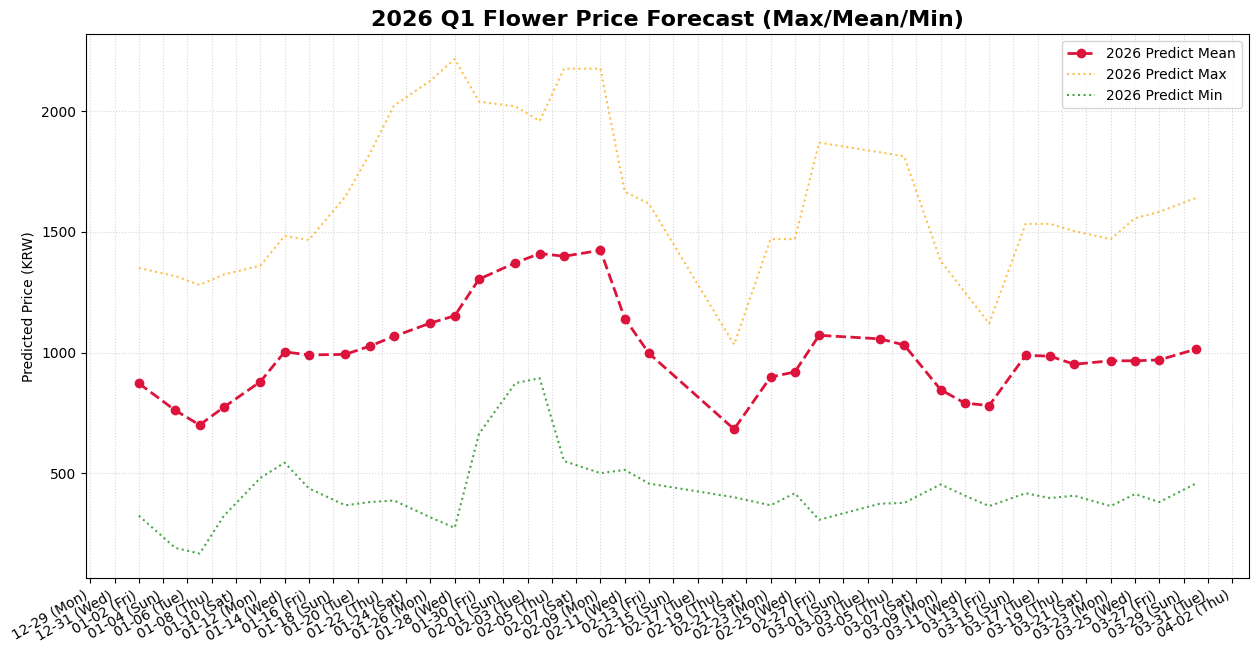

In [ ]:
# 2026년 경매 날짜 생성 및 시각화
prediction_dates_2026 = pd.date_range(start='2026-01-01', periods=future_steps, freq=auction_cal)

plt.figure(figsize=(15, 8))
plt.plot(prediction_dates_2026, forecast_reshaped[:, 1], label='2026 Predict Mean', color='crimson', linestyle='--', marker='o', linewidth=2)
plt.plot(prediction_dates_2026, forecast_reshaped[:, 0], label='2026 Predict Max', color='orange', linestyle=':', alpha=0.7)
plt.plot(prediction_dates_2026, forecast_reshaped[:, 2], label='2026 Predict Min', color='green', linestyle=':', alpha=0.7)

# x축 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d (%a)'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gcf().autofmt_xdate()

plt.title('2026 Q1 Flower Price Forecast (Max/Mean/Min)', fontsize=16, fontweight='bold')
plt.ylabel('Predicted Price (KRW)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()